Automation of stochastic memristor model

1. Import and process raw data

In [55]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy as sc
import keras

1.1 Import data

In [56]:
d1 = pd.read_csv('data/T1.csv')
d2 = pd.read_csv('data/T2.csv')
d3 = pd.read_csv('data/T3.csv')
d4 = pd.read_csv('data/T4.csv')
d5 = pd.read_csv('data/T5.csv')
d6 = pd.read_csv('data/T6.csv')
d7 = pd.read_csv('data/T7.csv')
d8 = pd.read_csv('data/T8.csv')
d9 = pd.read_csv('data/T9.csv')
d10 = pd.read_csv('data/T10.csv')
d11 = pd.read_csv('data/T11.csv')
d12 = pd.read_csv('data/T12.csv')
d13 = pd.read_csv('data/T13.csv')
d14 = pd.read_csv('data/T14.csv')
d15 = pd.read_csv('data/T15.csv')

In [57]:
# Create training data from the first 10 data cycles
d_train = pd.concat([d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11, d12, d13, d14, d15], ignore_index=True)

print(d_train.shape[0])
d_train.head()

660000


,Wordline,Bitline,Resistance,AmplitudeV,PulseWidths,Tag,ReadTag,ReadVoltage
0,27,3,79073.046875,-3.5,0.0001,P,2,0.5
1,27,3,76414.804688,-3.5,0.0001,P,2,0.5
2,27,3,75922.257812,-3.5,0.0001,P,2,0.5
3,27,3,73590.890625,-3.5,0.0001,P,2,0.5
4,27,3,72749.125000,-3.5,0.0001,P,2,0.5


1.2. Preprocessing 

In [58]:
# Extract resistance column from total training data

r_train = d_train['Resistance']

print(r_train)


0          79073.046875
1          76414.804688
2          75922.257812
3          73590.890625
4          72749.125000
              ...      
659995    219794.640625
659996    216984.437500
659997    219396.546875
659998    222959.171875
659999    226844.015625
Name: Resistance, Length: 660000, dtype: float64


In [59]:
# Sort the state resistance into a new data frame (only write pulses (pulse 101th-300th of a 400-pulse cycle)), also removing readings for 0.5V and 0.6V
R = pd.DataFrame()
r_1 = []
for j in range(20):
    for i in range(75):
        r_2 = r_train.iloc[(8800*(i)+400*(j+2)+100):(8800*(i)+400*(j+2)+300)]
        r_1.append(r_2)
    R[j] = pd.concat(r_1, axis=0).reset_index(drop=True)
    r_1 = []
    
print(R.shape)
R.head()

(15000, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,67612.851562,67799.210938,71097.695312,73636.132812,75726.695312,79077.757812,81075.078125,83114.234375,84356.015625,90949.820312,96266.554688,99131.164062,100358.242188,104421.937500,109854.070312,111565.578125,127223.734375,134453.656250,137114.531250,149979.171875
1,67632.937500,70102.929688,75312.234375,77246.796875,75956.195312,80083.585938,82258.171875,90547.484375,87794.632812,96495.343750,102089.937500,103729.906250,105773.296875,110892.226562,116573.687500,120727.531250,138877.375000,139415.046875,149419.187500,164528.468750
2,67122.820312,69543.023438,74874.773438,78157.367188,79954.703125,82999.875000,83998.992188,93683.281250,93039.750000,99576.640625,106409.835938,109517.406250,108799.437500,117222.632812,119179.242188,122335.765625,143525.734375,144589.484375,157162.468750,165268.281250
3,66984.820312,70945.859375,78232.460938,79300.421875,82811.304688,85266.171875,86756.421875,93978.773438,97688.132812,101519.226562,109005.218750,109517.242188,110770.421875,123284.156250,125552.390625,131349.562500,146293.859375,147564.921875,159704.234375,171873.718750
4,67170.968750,71231.281250,76769.679688,80917.765625,82449.210938,85064.429688,89387.984375,95728.031250,98140.429688,102067.937500,109788.218750,113915.765625,116796.062500,121920.039062,128476.710938,130533.148438,150669.890625,149241.609375,159646.578125,171601.906250


In [60]:
# Calculate delta R from the extracted state resistance
R_delta = pd.DataFrame()
rd_1 = []
for j in range(20):
    for i in range(75):
        rd_2 = r_train.iloc[(8800*(i)+400*(j+2)+101):(8800*(i)+400*(j+2)+301)].reset_index(drop=True)
        rd_3 = r_train.iloc[(8800*(i)+400*(j+2)+100):(8800*(i)+400*(j+2)+300)].reset_index(drop=True)
        rd = rd_2 - rd_3
        rd_1.append(rd)
    R_delta[j] = pd.concat(rd_1, axis=0).reset_index(drop=True)
    rd_1 = []

R_delta.head()
print(R_delta.shape)
    

(15000, 20)


In [61]:
# function to map indexes to voltage values
def mapv(i):
    if i<3:
        v = 0.7 + 0.1*i
    else:
        v = 0.85 + 0.05*i
    v = "{:.2f}".format(v)
    return v

In [62]:
# data frame with deltaR, R, and v
dfRR = []
for i in range(20):
    df = pd.DataFrame(columns=['R', 'deltaR', 'v'])
    df['R'] = R[i]
    df['deltaR'] = R_delta[i]
    df['v'] = mapv(i)
    dfRR.append(df)
dfRR = pd.concat(dfRR, axis=0)
dfRR.shape
dfRR = dfRR.astype(float)

In [63]:
# Scatter plot for delta resistance vs state resistance
fig = go.Figure()
for val in (1, 1.4, 1.8):               #for certain voltage levels
# for val in dfRR['v'].unique():          #for all voltage levels
    data = dfRR.loc[dfRR['v']==val]
    fig.add_trace(go.Scatter(y = data['deltaR'],
                             x = data['R'],
                             mode='markers',
                             name=f'{val} V'))
fig.update_layout(
    height=600,
    font_size=20,
    title="\u0394R vs R",
    xaxis_title="R (\u03A9)",
    yaxis_title="\u0394R (\u03A9)",
    xaxis_range=[60000,250000],
    yaxis_range=[-25000,25000],
)
fig.show()

2. Extract meaningful patterns from delta R

In [64]:
# Sort state R into bins
bin_width = 100                     #bin width
periods = int(200000/bin_width)     #corresponding number of bins
bin_series =pd.DataFrame()
bins = pd.interval_range(start=50000, end=250000, periods=periods) 

for j in range(20): 
    bin_series[j] = pd.cut(R[j], bins=bins).apply(lambda x: x.left)
    

print(bin_series[19])

0        149900
1        164500
2        165200
3        171800
4        171600
          ...  
14995    235800
14996    232900
14997    231000
14998    240300
14999    235600
Name: 19, Length: 15000, dtype: category
Categories (2000, int64): [50000 < 50100 < 50200 < 50300 ... 249600 < 249700 < 249800 < 249900]


In [65]:
# Create new data frames with binned resistance as secondary columns
R_delta_bins = pd.DataFrame()   # for R_delta
R_bins = pd.DataFrame()         # for R (not needed)
for i in range(20):
    R_delta_bins[2*i] = R_delta[i]
    R_delta_bins[2*i+1] = bin_series[i]
    #
    R_bins[2*i] = R[i]
    R_bins[2*i+1] = bin_series[i]
R_delta_bins.head()


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,20.085938,67600,2303.718750,67700,4214.539062,71000,3610.664062,73600,229.500000,75700,...,9161.953125,111500,11653.640625,127200,4961.390625,134400,12304.656250,137100,14549.296875,149900
1,-510.117188,67600,-559.906250,70100,-437.460938,75300,910.570312,77200,3998.507812,75900,...,1608.234375,120700,4648.359375,138800,5174.437500,139400,7743.281250,149400,739.812500,164500
2,-138.000000,67100,1402.835938,69500,3357.687500,74800,1143.054688,78100,2856.601562,79900,...,9013.796875,122300,2768.125000,143500,2975.437500,144500,2541.765625,157100,6605.437500,165200
3,186.148438,66900,285.421875,70900,-1462.781250,78200,1617.343750,79300,-362.093750,82800,...,-816.414062,131300,4376.031250,146200,1676.687500,147500,-57.656250,159700,-271.812500,171800
4,237.617188,67100,157.007812,71200,1294.734375,76700,912.671875,80900,-337.453125,82400,...,968.992188,130500,-944.500000,150600,4323.906250,149200,2874.578125,159600,1421.125000,171600


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_4552\1521307087.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='19', ylabel='Density'>

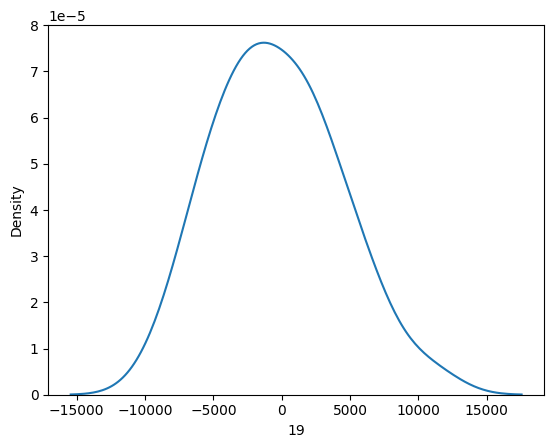

In [75]:
# Check Gaussianity within each bin
vl = 19 # chooses voltage index
index_groups = bin_series[vl].groupby(bin_series[vl])

binn = 220000   # Choose which bin to check
indexes = index_groups.groups[binn]

# plt.scatter([p] * len(indexes), R_delta[bin_no][indexes])
# plt.show()
sns.kdeplot(R_delta[vl][indexes])


2.1 Create deltaR mean dataframe

In [67]:
# Create new data frame for R_delta_mean, v and Rbin
df_mean=[]
for i in range(20):
    df = pd.DataFrame(columns=['mean', 'v_index', 'npt'])
    for val in R_delta_bins[2*i+1].unique():
        mean = R_delta_bins.loc[R_delta_bins[2*i+1]==val,2*i].mean()
        npt = R_delta_bins.loc[R_delta_bins[2*i+1]==val].shape[0]
        df.loc[val] = [mean, int(i), npt]
    df['v_index'] = df['v_index'].astype(int)
    df_mean.append(df)
df_mean = pd.concat(df_mean, axis=0)

df_mean = df_mean.reset_index().rename(columns={'index': 'Rbin'})   # Reset index
df_mean['v_index'] = df_mean['v_index'].apply(lambda x: mapv(x))    # Replace voltage index by value
df_mean.columns = ['Rbin', 'mean', 'v', 'npt']                      # Rename clumns
df_mean.head()

,Rbin,mean,v,npt
0,67600,-245.015625,0.70,2.0
1,67100,49.808594,0.70,2.0
2,66900,186.148438,0.70,1.0
3,67400,413.269531,0.70,2.0
4,67000,278.406250,0.70,1.0


In [68]:
## Export df_mean
# df_mean.to_csv('data/df_mean.csv')

2.2 Create deltaR std dataframe

In [69]:
# Create new data frame for R_delta_std, v and Rbin
df_std=[]
for i in range(20):
    df = pd.DataFrame(columns=['std', 'v_index', 'npt'])
    for val in R_delta_bins[2*i+1].unique():
        std = R_delta_bins.loc[R_delta_bins[2*i+1]==val,2*i].std()
        npt = R_delta_bins.loc[R_delta_bins[2*i+1]==val].shape[0]
        df.loc[val] = [std, int(i), npt]
    df['v_index'] = df['v_index'].astype(int)
    df_std.append(df)
df_std = pd.concat(df_std, axis=0)

df_std = df_std.reset_index().rename(columns={'index': 'Rbin'}) # Reset index
df_std['v_index'] = df_std['v_index'].apply(lambda x: mapv(x))  # Replace voltage index by value
df_std.columns = ['Rbin', 'std', 'v', 'npt']                    # Rename columns
df_std.head()

,Rbin,std,v,npt
0,67600,374.910225,0.70,2.0
1,67100,265.601460,0.70,2.0
2,66900,NaN,0.70,1.0
3,67400,1161.748820,0.70,2.0
4,67000,NaN,0.70,1.0


In [70]:
## Extract df_std
# df_std.to_csv('data/df_std.csv')

In [71]:
# Plot number of data points per bin
fig = go.Figure()

for val in df_std['v'].unique():
    data = df_std.loc[df_std['v']==val]
    fig.add_trace(go.Scatter(y = data['npt'],
                             x = data['Rbin'],
                             mode='markers',
                             name=f'{val}V'))
fig.update_layout(
    title="\u0394R\u03C3 vs Rbin",
    xaxis_title="Rbin",
    yaxis_title="\u0394R\u03C3"
)